In [1]:
import s3fs
import zarr
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import dask.array as da
from pyspark.sql import SparkSession

import os
import sys
import requests
import intake

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable


HOST = 'localhost'
PORT = 80
ENDPOINT_URI = f'http://{HOST}:{PORT}'

# Loading MAST Data With Spark


Then we need to create a spark context. This includes the number of parallel processes to use. In our case we are using 4 processes on the local machine.

In [2]:
spark = (SparkSession.builder
      .master("local[4]")
      .appName("mast")
       .config("spark.driver.memory", "15g") \
      .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/19 11:02:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/09/19 11:02:31 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
catalog = intake.open_catalog(f'{ENDPOINT_URI}/meta_catalog.yml')
signal_datasets = catalog.signal_datasets.read()
signal_dataset = signal_datasets.loc[signal_datasets.name == 'AMC_PLASMA_CURRENT'].squeeze()
signal_dataset

context_                                {'@vocab': ''}
name                                AMC_PLASMA_CURRENT
description                             Plasma Current
signal_type                                   Analysed
quality                                    Not Checked
doi                                                   
dimensions                                    ['time']
signal_dataset_id                                  569
units                                               kA
rank                                                 1
url                  s3://mast/AMC_PLASMA_CURRENT.zarr
Name: 568, dtype: object

Open the relevant Zarr archive and get the groups

In [4]:
s3 = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': f"http://{HOST}:9000" })

store = zarr.storage.FSStore(signal_dataset.url, fs=s3)
handle = zarr.open_consolidated(store)
groups = list(handle.groups())

We're going to perform a simple plotting task. We will:

 - Load the plasma current data as a `xarray.Dataset`
 - Slice every shot between 0 seconds and .2 seconds.
 
In the cell below we do not perform any computation. We only setup the operations we wish to perform.

In [31]:
def load_group(group):
    dataset = xr.Dataset(
        dict(data=xr.DataArray(group['data'], dims=['time']),
             error=xr.DataArray(group['error'], dims=['time']), 
            time=xr.DataArray(group['time'], dims=['time'])))
    return dataset
    
rdd = spark.sparkContext.parallelize(reversed(groups), 10)
rdd = rdd.map(lambda item: load_group(item[1]))
rdd = rdd.map(lambda dataset: dataset.sel(time=slice(0, .3)))
rdd = rdd.cache()

Finally, we want to plot the last 10 shots. `rdd.take` will process just `10` items and return the results as a list 

CPU times: user 33.8 ms, sys: 7.23 ms, total: 41 ms
Wall time: 1.07 s


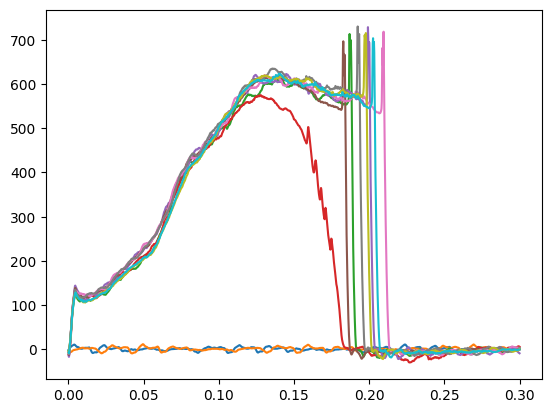

In [33]:
%%time
for current in rdd.take(10):
    plt.plot(current.time, current.data)

### Fast Reductions for Analysis

Let's try something more compute intensive. Here we are going to:

 - Load all of the plasma current data each as a `xarray.Dataset`
 - Slice the current between `0` and `.2` seconds
 - Take the average of the plasma current
 - Filter any shots with an average current less than `5.0`
 
Again, below we only setup the computational steps. The next cell will execute the reduction.

In [36]:
def load_group(group):
    dataset = xr.Dataset(
        dict(data=xr.DataArray(group['data'], dims=['time']),
            time=xr.DataArray(group['time'], dims=['time'])))
    return dataset
    
rdd = spark.sparkContext.parallelize(reversed(groups), 100)
keys = rdd.map(lambda item: int(item[0]))

# rdd = rdd.map(lambda item: xr.open_zarr(store, group=item[0], chunks=None))
rdd = rdd.map(lambda item: load_group(item[1]))
rdd = rdd.map(lambda dataset: dataset.sel(time=slice(0., .2)))
rdd = rdd.map(lambda dataset: dataset['data'].mean().values)
rdd = rdd
rdd.cache()

result = keys.zip(rdd).filter(lambda item: item[1] > 100.0)

Let's collect the results and plot the average current as a function of shot number

23/08/24 16:11:08 WARN TaskSetManager: Stage 7 contains a task of very large size (1953 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 103 ms, sys: 16.5 ms, total: 120 ms
Wall time: 26.8 s


Text(0, 0.5, 'current')

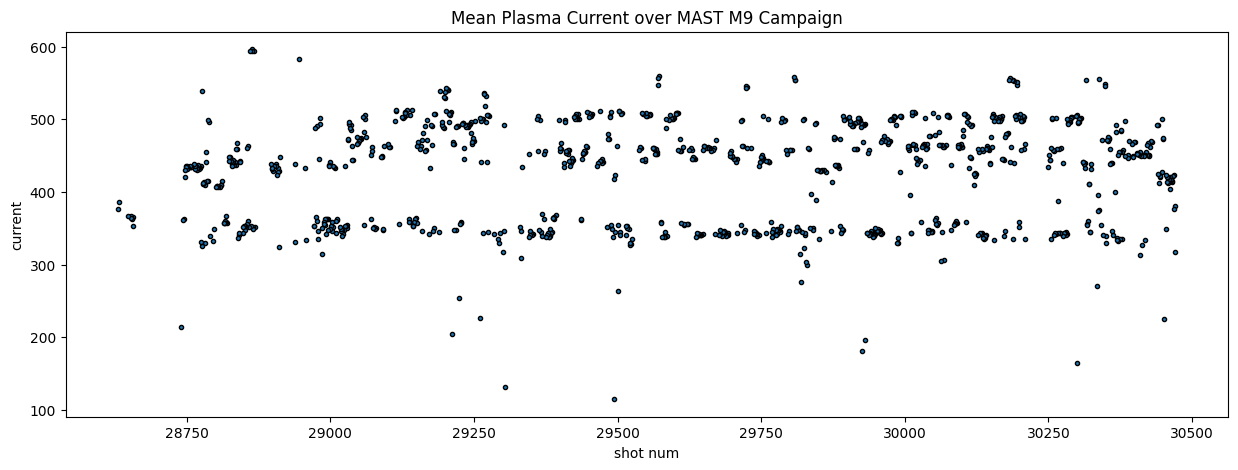

In [37]:
%%time
results = result.collect()
df = pd.DataFrame(results, columns=['shot', 'mean_current'])

plt.figure(figsize=(15, 5))
plt.scatter(df.shot, df.mean_current, marker='.', edgecolor='black')
plt.title('Mean Plasma Current over MAST M9 Campaign')
plt.xlabel('shot num')
plt.ylabel('current')

## Larger Data - Raw IR Data

In [48]:
store = s3fs.S3Map(root=f'mast/rir.zarr', s3=s3, check=False)
handle = zarr.open_consolidated(store)
groups = list(handle.groups())

keys = [k for k, g in groups]

for k in keys:
    handle[k]

In [10]:
from skimage.exposure import equalize_adapthist, rescale_intensity
from skimage.filters import median

def process_image(ds):
    img = ds['data'].mean('time') # average across time
    img = median(img)             # median filter 
    img = rescale_intensity(img)  # rescale to 0-1 range
    # img = equalize_adapthist(img)
    return img
    
rdd = spark.sparkContext.parallelize(reversed(groups), 100)
rdd = rdd.filter(lambda item: item[1]['data'].shape[1] > 200)
rdd = rdd.map(lambda item: xr.open_zarr(store, group=item[0]))
rdd = rdd.map(process_image)
# rdd = rdd.cache()

In [11]:
%%time
results = rdd.collect()

23/08/23 12:39:14 WARN TaskSetManager: Stage 2 contains a task of very large size (1266 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 80.1 ms, sys: 127 ms, total: 207 ms
Wall time: 22.9 s


In [12]:
len(results)

219

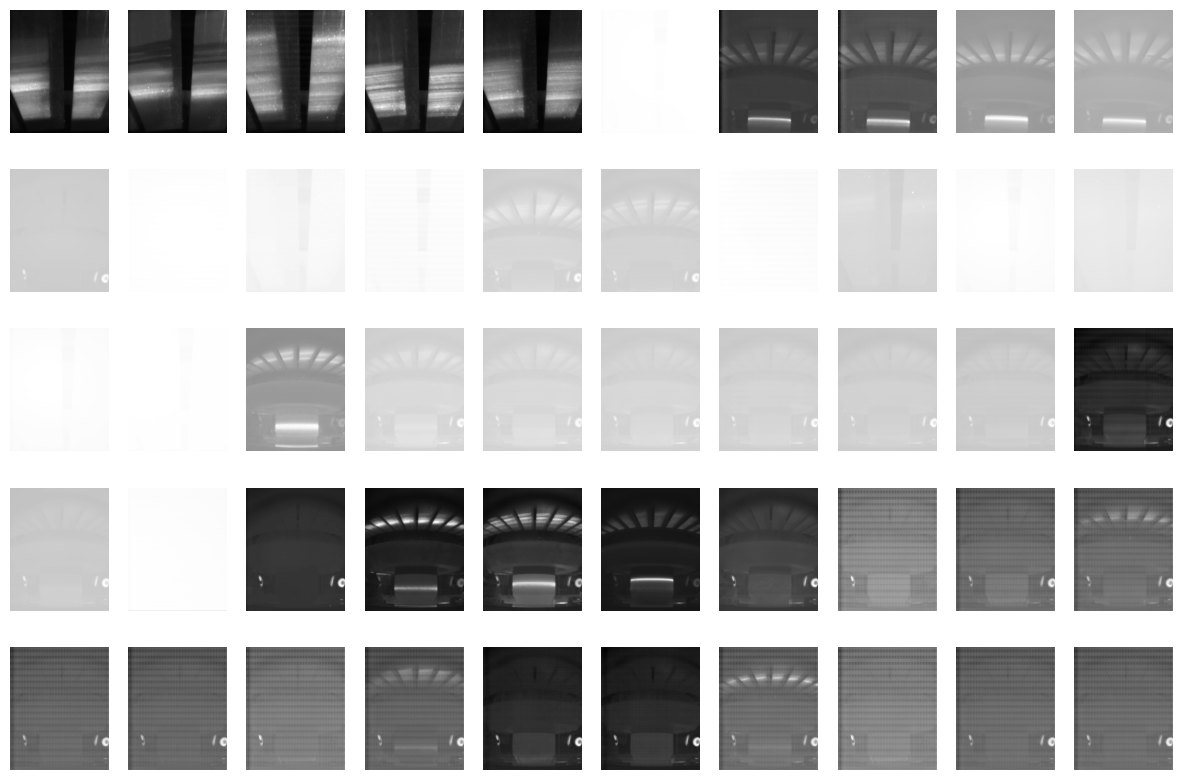

In [13]:
fig, axes = plt.subplots(5, 10, figsize=(15, 10))
for ax, item in zip(axes.flatten(), results[::2]):
    ax.imshow(item.T, cmap='gray')
    ax.axis('off')